# Load data from file

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
sst_home='drive/My Drive/Trabajo PLN/'
train = pd.read_csv(sst_home+"/Dataset/train_data.csv",  names=["headline"])
test = pd.read_csv(sst_home+"/Dataset/trial_data.csv", names=["headline"])
train_label_1 = pd.read_csv(sst_home+"/Dataset/train_labels_subtask_1.csv", names=["Value"])
train_label_2 = pd.read_csv(sst_home+"/Dataset/train_labels_subtask_2.csv", names=["Value 1", "Value 2", "Value 3", "Value 4", "Value 5" ])
test_label_1 = pd.read_csv(sst_home+"/Dataset/trial_labels_subtask_1.csv", names=["Value"])
test_label_2 = pd.read_csv(sst_home+"/Dataset/trial_labels_subtask_2.csv", names=["Value 1", "Value 2", "Value 3", "Value 4", "Value 5" ])

# Train data
X_train = train['headline'].tolist()
y_train = train_label_1['Value'].array

# Splitting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Trial data
X_test = test['headline']
y_test = test_label_1['Value']

Mounted at /content/drive


# Installing hugginface transformers

In [ ]:
!pip3 install transformers numpy torch sklearn

     |████████████████████████████████| 3.8 MB 4.9 MB/s 
     |████████████████████████████████| 895 kB 40.9 MB/s 
     |████████████████████████████████| 596 kB 45.7 MB/s 
     |████████████████████████████████| 77 kB 5.9 MB/s 
     |████████████████████████████████| 6.5 MB 37.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Setting up BERT

In [ ]:
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import numpy as np
import random

In [ ]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
model_name = "bert-base-multilingual-uncased"

# max sequence length for each document/sentence sample
max_length = 512

# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=max_length)


class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = TorchDataset(train_encodings, y_train)
val_dataset = TorchDataset(val_encodings, y_val)

Downloading:   0%|          | 0.00/152 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

# Training the model

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to("cuda")

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=400,               # log & save weights each logging_steps
    save_steps=400,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

# train the model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2689
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1011


Step,Training Loss,Validation Loss,Accuracy
400,0.596300,0.608356,0.741456
800,0.605300,0.675964,0.472511


***** Running Evaluation *****
  Num examples = 673
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 673
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-800
Configuration saved in ./results/checkpoint-800/config.json
Model weights saved in ./results/checkpoint-800/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-400 (score: 0.6083563566207886).


TrainOutput(global_step=1011, training_loss=0.5826774921662494, metrics={'train_runtime': 1183.9279, 'train_samples_per_second': 6.814, 'train_steps_per_second': 0.854, 'total_flos': 1189770206230620.0, 'train_loss': 0.5826774921662494, 'epoch': 3.0})

In [ ]:
# evaluate the current model after training
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 673
  Batch size = 20


{'epoch': 3.0,
 'eval_accuracy': 0.7414561664190193,
 'eval_loss': 0.6083563566207886,
 'eval_runtime': 12.8923,
 'eval_samples_per_second': 52.202,
 'eval_steps_per_second': 2.637}

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "davincis-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in davincis-uncased/config.json
Model weights saved in davincis-uncased/pytorch_model.bin
tokenizer config file saved in davincis-uncased/tokenizer_config.json
Special tokens file saved in davincis-uncased/special_tokens_map.json


('davincis-uncased/tokenizer_config.json',
 'davincis-uncased/special_tokens_map.json',
 'davincis-uncased/vocab.txt',
 'davincis-uncased/added_tokens.json',
 'davincis-uncased/tokenizer.json')

In [ ]:
!pip install scikit-plot

              precision    recall  f1-score   support

           0       0.71      0.74      0.73        27
           1       0.68      0.65      0.67        23

    accuracy                           0.70        50
   macro avg       0.70      0.70      0.70        50
weighted avg       0.70      0.70      0.70        50



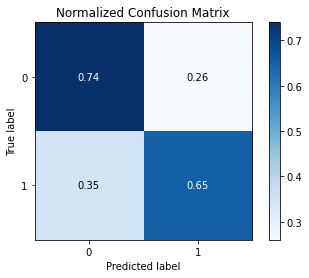

In [ ]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    # return probs.argmax() is a tensor. We have to return its item
    return probs.argmax().item()

y_pred=[]
for text in X_test:
    y_pred.append(get_prediction(text))

from sklearn.metrics import confusion_matrix, classification_report
import scikitplot as skplt

print(classification_report(y_test, y_pred))

plot = skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
